<a href="https://colab.research.google.com/github/ahsanrazi/LangChain/blob/main/04_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent

In [1]:
# By themselves, language models can't take actions - they just output text.

# Agents are systems that use LLMs as reasoning engines to determine which actions to take and the inputs necessary to perform the action.
# After executing actions, the results can be fed back into the LLM to determine whether more actions are needed, or whether it is okay to finish.
# This is often achieved via tool-calling.

In [2]:
# In this we will build an agent that can interact with a search engine.

In [4]:
%pip install -qU langchain-community
%pip install -qU langgraph
%pip install -qU langchain-google-genai
%pip install -qU tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.6 MB/s eta 0:00:00


In [9]:
from google.colab import userdata
import os

gemini_api_key = userdata.get('GEMINI_API_KEY').strip()
tavily_api_key = userdata.get('TAVILY_API_KEY').strip()

# Set the environment variable 'TAVILY_API_KEY'
os.environ['TAVILY_API_KEY'] = tavily_api_key

# Define tools

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=2)
search_results = search.invoke("what is the weather in SF")
print(search_results)

# If we want, we can create other tools.
# Once we have all the tools we want, we can put them in a list that we will reference later.
tools = [search]

[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1738238266, 'localtime': '2025-01-30 03:57'}, 'current': {'last_updated_epoch': 1738237500, 'last_updated': '2025-01-30 03:45', 'temp_c': 10.1, 'temp_f': 50.2, 'is_day': 0, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/night/122.png', 'code': 1009}, 'wind_mph': 2.7, 'wind_kph': 4.3, 'wind_degree': 297, 'wind_dir': 'WNW', 'pressure_mb': 1023.0, 'pressure_in': 30.21, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 77, 'cloud': 100, 'feelslike_c': 10.1, 'feelslike_f': 50.2, 'windchill_c': 6.4, 'windchill_f': 43.6, 'heatindex_c': 6.8, 'heatindex_f': 44.2, 'dewpoint_c': 6.1, 'dewpoint_f': 42.9, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 0.0, 'gust_mph': 4.3, 'gust_kph': 6.8}}"}, {'url': 'https://weathershogun.com/weather/usa/ca/

# Using Language Models

In [24]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model = "gemini-2.0-flash-exp", api_key=gemini_api_key)

In [25]:
from langchain_core.messages import HumanMessage

response = model.invoke([HumanMessage(content="hi!")])
response.content

'Hi there! How can I help you today? 😊'

In [26]:
# we use .bind_tools to give the language model knowledge of these tools

model_with_tools = model.bind_tools(tools)

In [37]:
# Let's first call it with a normal message, and see how it responds. We can look at both the content field as well as the tool_calls field.

response = model_with_tools.invoke([HumanMessage(content="Hi!")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: Hello! How can I help you today?
ToolCalls: []


In [35]:
# let's try calling it with some input that would expect a tool to be called.

response = model_with_tools.invoke([HumanMessage(content="What's the weather in SF?")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: 
ToolCalls: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': '5ea752d9-aca6-481c-8b87-5fb1bcc2db6d', 'type': 'tool_call'}]


# Create the agent

In [30]:
# Now that we have defined the tools and the LLM, we can create the agent. We will be using LangGraph to construct the agent.

# we are using a high level interface to construct the agent.
# we are passing in the "model", not "model_with_tools". That is because "create_react_agent" will call ".bind_tools" for us under the hood.

from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model, tools)

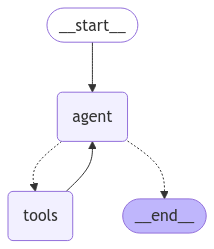

In [33]:
agent_executor

# Run the agent

In [31]:
"""
We can now run the agent with a few queries! Note that for now, these are all stateless queries (it won't remember previous interactions).
Note that the agent will return the final state at the end of the interaction (which includes any inputs, we will see later on how to get only the outputs).
"""

response = agent_executor.invoke({"messages": [HumanMessage(content="hi!")]})
response["messages"]

[HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='83219e56-fa81-4ea6-a00c-8b7640eca5ee'),
 AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-431bd07e-6634-4ad8-a575-1d19aa94ea90-0', usage_metadata={'input_tokens': 76, 'output_tokens': 10, 'total_tokens': 86, 'input_token_details': {'cache_read': 0}})]

In [34]:
response = agent_executor.invoke({"messages": [HumanMessage(content="whats the weather in sf?")]})
response["messages"]

[HumanMessage(content='whats the weather in sf?', additional_kwargs={}, response_metadata={}, id='4028c4d8-dd35-48b4-b22d-b3bf2c52b561'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in San Francisco"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-de04ec1b-6242-4f8d-962f-d150b9a78bcb-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': '3f580b90-d5e4-48d9-97c0-cdc570824352', 'type': 'tool_cal

# Streaming Messages

In [39]:
for chunk in agent_executor.stream({"messages": [HumanMessage(content="whats the weather in sf?")]}):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in san francisco"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b1b08c9a-547b-4317-aa56-cacc388d80b5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in san francisco'}, 'id': 'f9551967-8c71-4574-9827-7ca3a6a086ed', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 13, 'total_tokens': 93, 'input_token_details': {'cache_r

# Adding in memory

In [40]:
# As mentioned earlier, this agent is stateless. This means it does not remember previous interactions.
# To give it memory we need to pass in a checkpointer.

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [41]:
agent_executor = create_react_agent(model, tools, checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

In [42]:
for chunk in agent_executor.stream(
    {"messages": [HumanMessage(content="hi im bob!")]}, config
):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content='Hello Bob! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ffdf9fa8-6840-451c-a0fe-b74612cedae0-0', usage_metadata={'input_tokens': 78, 'output_tokens': 11, 'total_tokens': 89, 'input_token_details': {'cache_read': 0}})]}}
----


In [43]:
for chunk in agent_executor.stream(
    {"messages": [HumanMessage(content="whats my name?")]}, config):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content='Your name is Bob.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-d27639e5-9d22-404c-86ac-81bf188b9a10-0', usage_metadata={'input_tokens': 94, 'output_tokens': 6, 'total_tokens': 100, 'input_token_details': {'cache_read': 0}})]}}
----


In [44]:
# If you want to start a new conversation, all you have to do is change the thread_id used

config = {"configurable": {"thread_id": "xyz123"}}
for chunk in agent_executor.stream(
    {"messages": [HumanMessage(content="whats my name?")]}, config
):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content="I do not have access to personal information, so I don't know your name.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-10c69ce6-189b-4bcf-b05d-d542e275410e-0', usage_metadata={'input_tokens': 78, 'output_tokens': 19, 'total_tokens': 97, 'input_token_details': {'cache_read': 0}})]}}
----


# Adding Prompt Template

In [74]:
# Step 1: Import Required Modules
from langchain_core.prompts import ChatPromptTemplate

# Step 2: Define the Chat Prompt Template
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("placeholder", "{messages}"),
])

agent_executor = create_react_agent(model, tools, prompt=prompt, checkpointer=memory)

config = {"configurable": {"thread_id": "abc13"}}


In [75]:
# Step 4: Invoke the Agent with a User Message
response = agent_executor.invoke({"messages": [HumanMessage(content="What is my name")]}, config)

In [76]:
# Accessing and printing the response messages
print(response["messages"])

[HumanMessage(content='Hi I am Ahsan', additional_kwargs={}, response_metadata={}, id='a1740264-0161-4c5a-8832-6852bc29ad63'), AIMessage(content="Hello Ahsan, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-50fa38d6-84fc-4f6b-bd0d-6b6d109d79f9-0', usage_metadata={'input_tokens': 85, 'output_tokens': 20, 'total_tokens': 105, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='5f08d8e4-12